In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


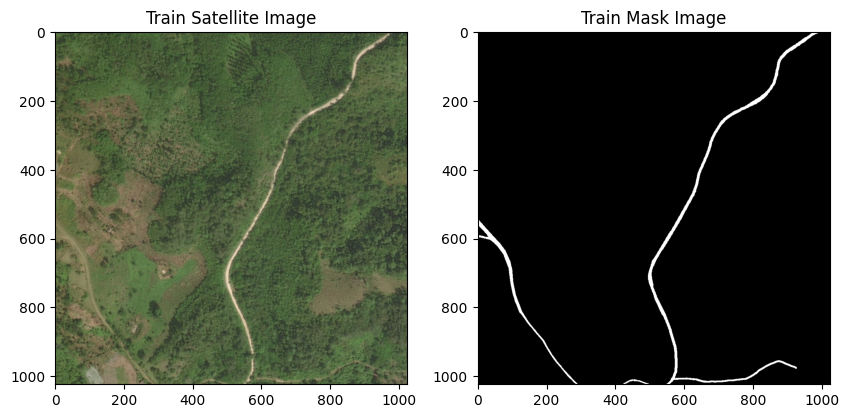

In [ ]:
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt

train_zip_path = '/content/drive/My Drive/Copy of train.zip'
test_zip_path = '/content/drive/My Drive/Copy of test.zip'
valid_zip_path = '/content/drive/My Drive/Copy of valid.zip'

extract_dirs = {
    'train': '/content/extracted_data/train',
    'test': '/content/extracted_data/test',
    'valid': '/content/extracted_data/valid'
}

for dir in extract_dirs.values():
    if not os.path.exists(dir):
        os.makedirs(dir)

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

extract_zip(train_zip_path, extract_dirs['train'])
extract_zip(test_zip_path, extract_dirs['test'])
extract_zip(valid_zip_path, extract_dirs['valid'])


def get_image_pairs(directory):
    extracted_files = os.listdir(directory)
    sat_images = sorted([f for f in extracted_files if 'sat' in f])
    mask_images = sorted([f for f in extracted_files if 'mask' in f])
    return sat_images, mask_images

train_sat_images, train_mask_images = get_image_pairs(extract_dirs['train'])
test_sat_images, test_mask_images = get_image_pairs(extract_dirs['test'])
valid_sat_images, valid_mask_images = get_image_pairs(extract_dirs['valid'])


def display_image_pair(sat_image_path, mask_image_path, title_prefix=''):
    sat_image = Image.open(sat_image_path)
    mask_image = Image.open(mask_image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f'{title_prefix} Satellite Image')
    plt.imshow(sat_image)
    plt.subplot(1, 2, 2)
    plt.title(f'{title_prefix} Mask Image')
    plt.imshow(mask_image, cmap='gray')
    plt.show()

if train_sat_images and train_mask_images:
    display_image_pair(os.path.join(extract_dirs['train'], train_sat_images[0]), os.path.join(extract_dirs['train'], train_mask_images[0]), 'Train')
if test_sat_images and test_mask_images:
    display_image_pair(os.path.join(extract_dirs['test'], test_sat_images[0]), os.path.join(extract_dirs['test'], test_mask_images[0]), 'Test')
if valid_sat_images and valid_mask_images:
    display_image_pair(os.path.join(extract_dirs['valid'], valid_sat_images[0]), os.path.join(extract_dirs['valid'], valid_mask_images[0]), 'Valid')


Data Generator Class

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import Sequence
import os

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, target_size=(256, 256)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            img = load_img(self.image_paths[i], target_size=self.target_size)
            mask = load_img(self.mask_paths[i], target_size=self.target_size, color_mode="grayscale")
            img_array = img_to_array(img)
            mask_array = img_to_array(mask)
            mask_array = np.where(mask_array > 128, 1, 0).astype(np.float32)
            batch_images.append(img_array)
            batch_masks.append(mask_array)

        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split # Import train_test_split

metadata_path = '/content/drive/My Drive/metadata.csv'
metadata = pd.read_csv(metadata_path)


metadata = metadata.dropna(subset=['mask_path'])


image_paths = [os.path.join('/content/extracted_data', row['sat_image_path']) for _, row in metadata.iterrows()]
mask_paths = [os.path.join('/content/extracted_data', row['mask_path']) for _, row in metadata.iterrows()]


train_image_paths, valid_image_paths, train_mask_paths, valid_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42)


In [ ]:
batch_size = 16

train_generator = DataGenerator(train_image_paths, train_mask_paths, batch_size=batch_size)
valid_generator = DataGenerator(valid_image_paths, valid_mask_paths, batch_size=batch_size)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


model = unet_model()

model.fit(train_generator, validation_data=valid_generator, epochs=25)


Epoch 1/25
312/312 [==============================] - 358s 1s/step - loss: 0.1844 - accuracy: 0.9559 - val_loss: 0.1396 - val_accuracy: 0.9571
Epoch 2/25
312/312 [==============================] - 255s 817ms/step - loss: 4.3330 - accuracy: 0.9387 - val_loss: 3.4033 - val_accuracy: 0.5402
Epoch 3/25
312/312 [==============================] - 249s 798ms/step - loss: 0.1996 - accuracy: 0.9562 - val_loss: 0.1710 - val_accuracy: 0.9567
Epoch 4/25
312/312 [==============================] - 249s 798ms/step - loss: 0.1626 - accuracy: 0.9578 - val_loss: 0.1665 - val_accuracy: 0.9567
Epoch 5/25
312/312 [==============================] - 249s 797ms/step - loss: 0.1619 - accuracy: 0.9578 - val_loss: 0.1672 - val_accuracy: 0.9567
Epoch 6/25
312/312 [==============================] - 249s 798ms/step - loss: 0.1595 - accuracy: 0.9578 - val_loss: 0.1629 - val_accuracy: 0.9567
Epoch 7/25
312/312 [==============================] - 249s 796ms/step - loss: 0.1572 - accuracy: 0.9578 - val_loss: 0.1578 - va

In [ ]:
from tensorflow.keras.metrics import MeanIoU
import numpy as np


y_valid_pred = model.predict(valid_generator)

y_valid_pred_binary = (y_valid_pred > 0.5).astype(np.float32)

iou = MeanIoU(num_classes=2)
iou.update_state(np.concatenate([valid_generator[i][1] for i in range(len(valid_generator))]),
                 y_valid_pred_binary[:len(valid_generator) * valid_generator.batch_size])
print(f"Mean IoU: {iou.result().numpy()}")

def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))

y_valid_true = np.concatenate([valid_generator[i][1] for i in range(len(valid_generator))])
dice = dice_coefficient(y_valid_true, y_valid_pred_binary[:len(valid_generator) * valid_generator.batch_size])
print(f"Dice Coefficient: {dice}")


78/78 [==============================] - 37s 459ms/step
Mean IoU: 0.38304954767227173
Dice Coefficient: 0.03451960020343736


1/1 [==============================] - 0s 28ms/step


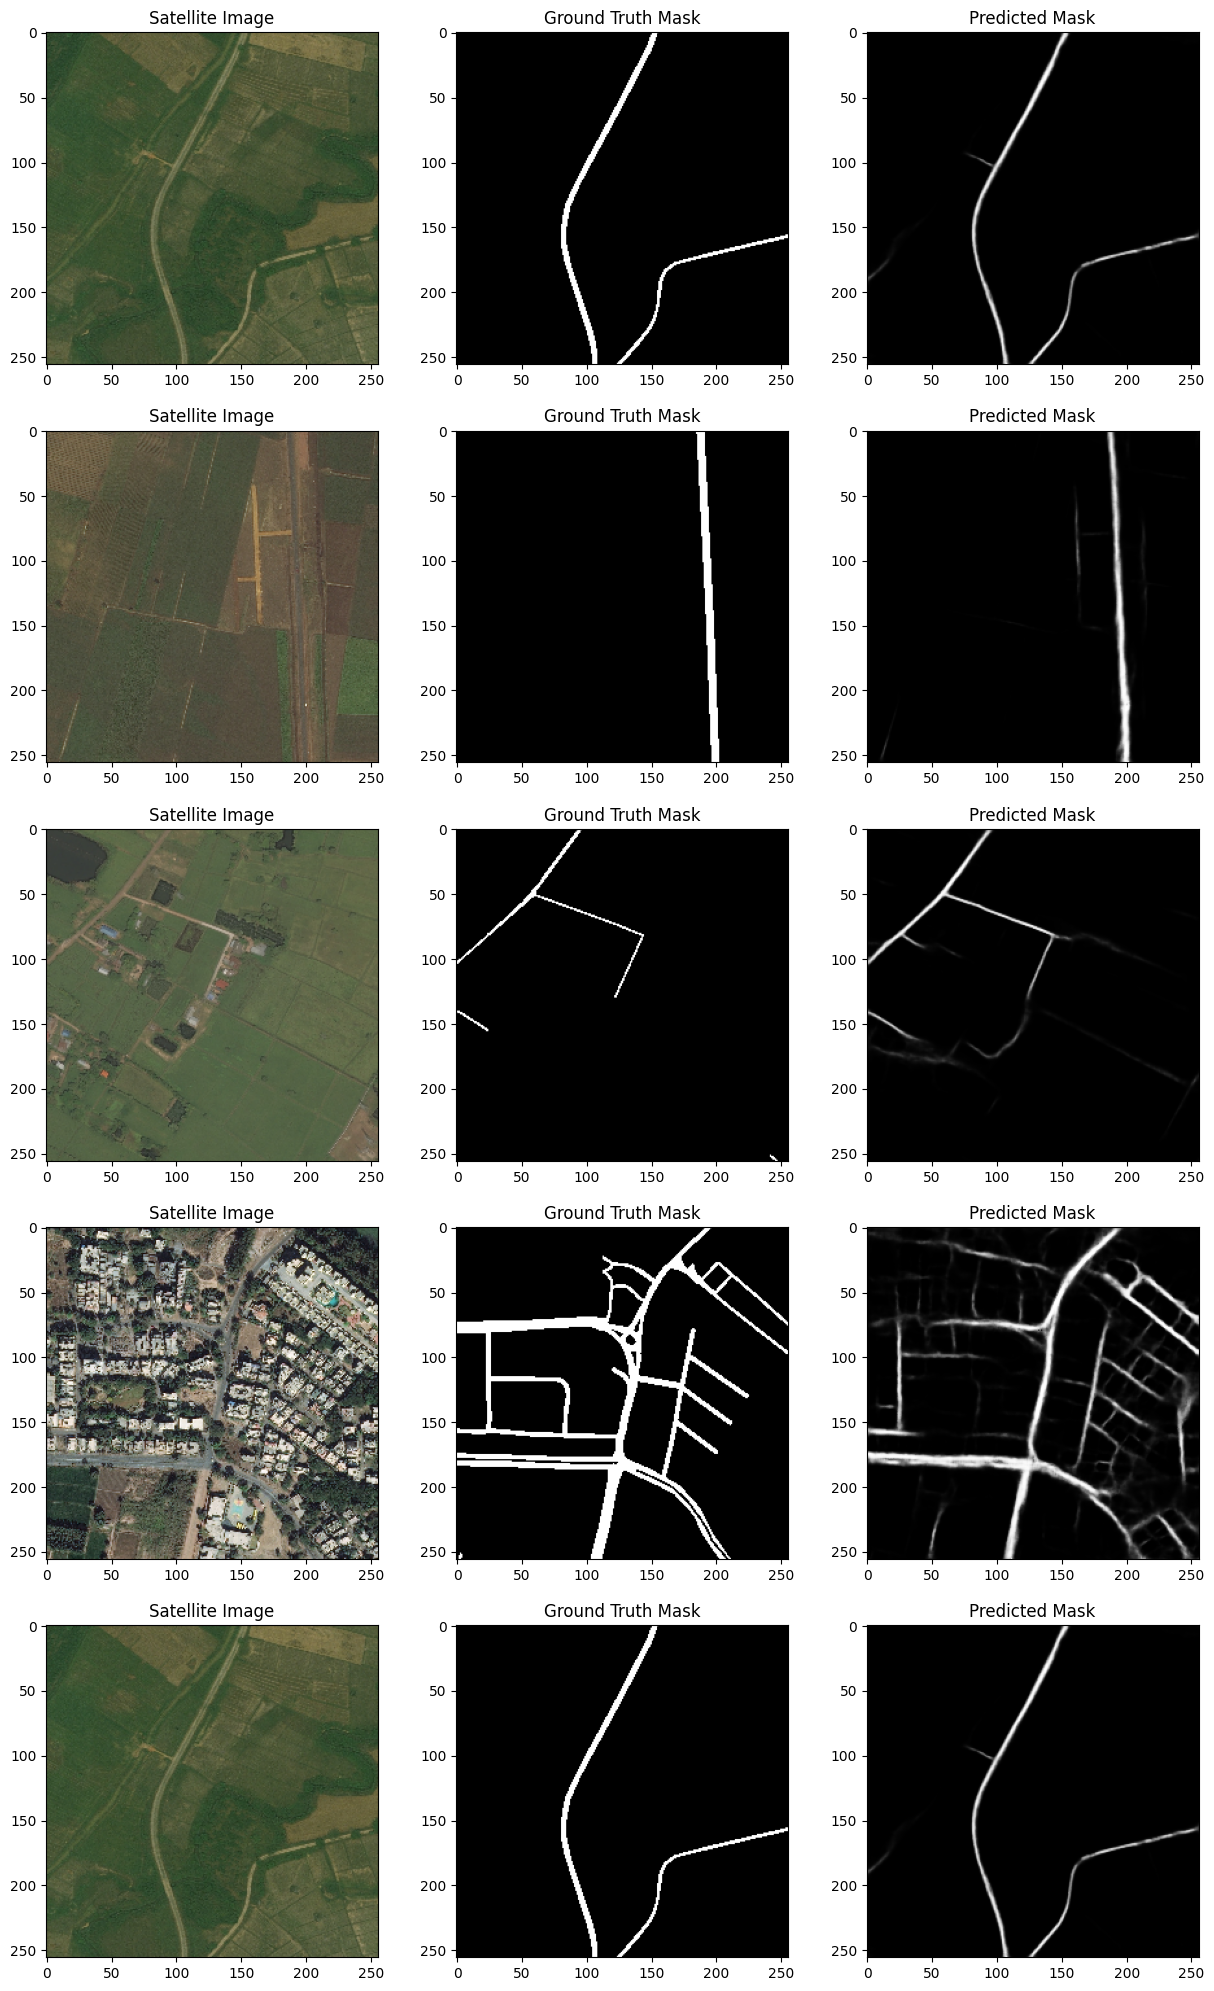

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def visualize_predictions(generator, model, num_samples=5):
    plt.figure(figsize=(15, num_samples * 5))

    for i in range(num_samples):
        idx = random.randint(0, len(generator) - 1)
        img, mask = generator[idx]

        pred_mask = model.predict(img)

        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.title("Satellite Image")
        plt.imshow(img[0].astype(np.uint8))


        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask[0].squeeze(), cmap='gray')


        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask[0].squeeze(), cmap='gray')

    plt.show()

visualize_predictions(valid_generator, model)
